___
<a href='https://cafe.naver.com/jmhonglab'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="50%" height="50%"/></p></a>
___
<center><em>Content Copyright by HongLab, Inc.</em></center>

# 비지도 학습(Unsupervised Learning)

### Auto-Encoder와 차원 축소(Dimensionality Reduction)

28 x 28 해상도의 이미지는 784차원의 데이터 -> 이것을 2차원으로 차원을 축소(dimensionality reduction)한다면?

In [80]:
import numpy as np
import torch

class AutoEncoder(torch.nn.Module):
    def __init__(self, dim_latent = 2):
        super().__init__()

        self.dim_latent = dim_latent

        # Encoder: 784 -> 128 -> 64 -> 2 (중간중간 ReLU, 마지막은 활성화함수 X)
        self.encoder = torch.nn.Sequential(
            pass
        )

        # Decoder: 2 -> 64 -> 128 -> 784 (중간중간 ReLU, 마지막은 Sigmoid())``
        self.decoder = torch.nn.Sequential(
            pass
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        self.z = self.encoder(x) # z로 저장
        return self.decoder(self.z)


torch.manual_seed(0)

x_input = np.load("MNIST_x_train.npy")
x_input = torch.tensor(x_input, dtype=torch.float).flatten(start_dim=1)

model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.BCELoss()
for epoch in range(1, 401):
    optimizer.zero_grad()
    y_pred = model(x_input)
    loss = criterion(y_pred, x_input)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: loss = {loss.item()}")


Epoch 50: loss = 0.24366721510887146
Epoch 100: loss = 0.233427956700325
Epoch 150: loss = 0.20677249133586884
Epoch 200: loss = 0.19413574039936066
Epoch 250: loss = 0.18816420435905457
Epoch 300: loss = 0.1868673712015152
Epoch 350: loss = 0.18349415063858032
Epoch 400: loss = 0.18216712772846222


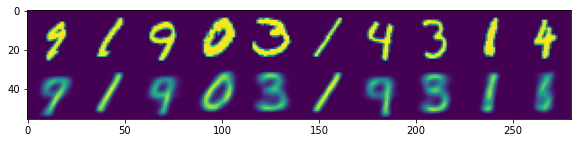

In [81]:
import matplotlib.pyplot as plt

def compare(model, n_samples = 20):
    x_np = np.load("MNIST_x_train.npy")
    x_np = x_np[np.random.choice(x_np.shape[0], n_samples)]
    y_pre = model.forward(torch.tensor(x_np, dtype=torch.float).flatten(start_dim=1)).detach().numpy()
    y_samples = y_pre.reshape(-1, 28, 28).transpose((1, 0, 2)).reshape(28, 28 * n_samples)
    x_samples = x_np.reshape(-1, 28, 28).transpose((1, 0, 2)).reshape(28, 28 * n_samples)

    plt.figure(figsize=(16, 2))
    plt.imshow(np.concatenate([x_samples, y_samples]))

compare(model, 10)
        

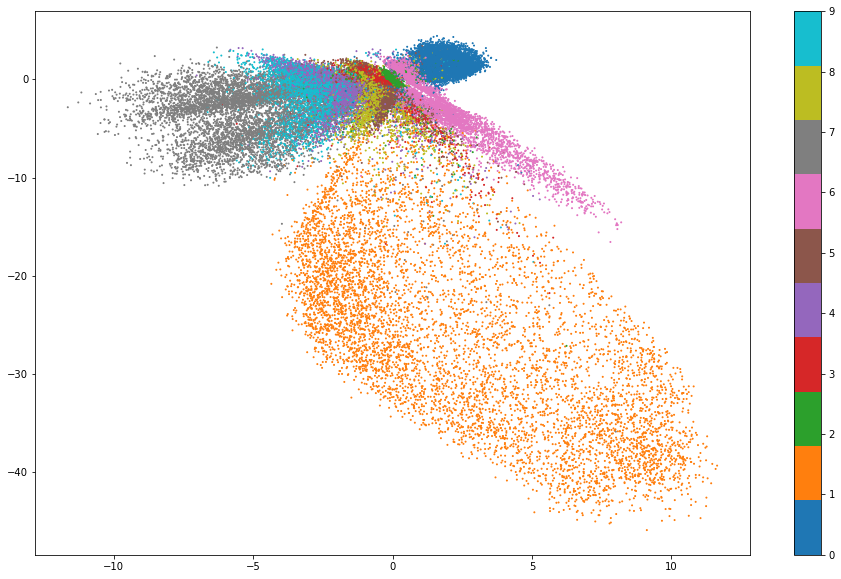

In [82]:
import matplotlib.pyplot as plt

def visualize(model):
    x_input = torch.tensor(np.load("MNIST_x_train.npy"), dtype=torch.float).flatten(start_dim=1)
    model.forward(x_input)
    z = model.z.detach().numpy() # (60000, 2)
    y_target = np.load("MNIST_y_train.npy") # 샘플 색 결정

    plt.figure(figsize=(16, 10))
    plt.scatter(z[:,0], z[:,1], c=y_target, cmap="tab10", s = 1)
    plt.colorbar()

visualize(model)

### Variational Auto-Encoder


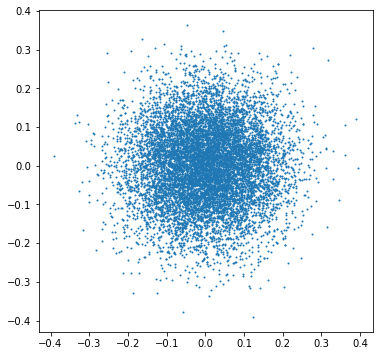

In [91]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.set_aspect(1.0)
plt.scatter(np.random.normal(0, 0.1, 10000), np.random.normal(0, 0.1, 10000), s = 1)
plt.show()

In [93]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self):
        self.x_input = np.load("MNIST_x_train.npy").astype(np.float32).reshape(-1, 28*28)

    def __len__(self):
        return len(self.x_input)

    def __getitem__(self, idx):
        return self.x_input[idx]

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoEncoder(torch.nn.Module):
    def __init__(self, dim_latent = 2):
        super().__init__()

        self.dim_latent = dim_latent

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, dim_latent * 2),# latent space dimension의 2배
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim_latent, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28*28),
        )

    def forward(self, x):
        x = self.encoder(x).view(-1, 2, self.dim_latent)

        # reparameterize
        self.mu = x[:, 0, :]
        self.sigma = torch.exp(x[:, 1, :])
        self.z = self.mu + self.sigma * torch.randn_like(self.mu)
        return self.decoder(self.z)

model = VariationalAutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

data_loader = DataLoader(MyDataset(), batch_size=1000, shuffle=True)

for epoch in range(1, 101):
    epoch_loss = 0.0
    for x_input in data_loader:
        optimizer.zero_grad()
        x_hat = model(x_input)

        mse_loss = ((x_input - x_hat)**2).sum()
        kl_loss = (model.sigma**2 + model.mu**2 - torch.log(model.sigma) - 0.5).sum()
        loss = mse_loss + kl_loss

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss = {loss.item()}")

Epoch 10: loss = 43662.86328125
Epoch 20: loss = 39685.94921875
Epoch 30: loss = 39082.29296875
Epoch 40: loss = 39209.9765625
Epoch 50: loss = 38424.6484375
Epoch 60: loss = 39020.2421875
Epoch 70: loss = 37631.734375
Epoch 80: loss = 37857.57421875
Epoch 90: loss = 38645.7578125
Epoch 100: loss = 38116.09765625


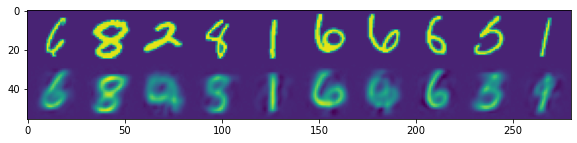

In [96]:
compare(model, 10)

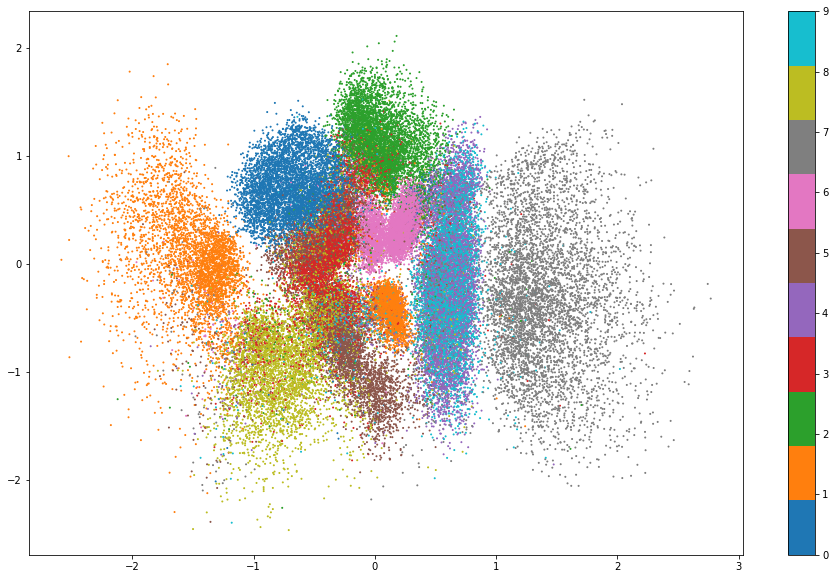

In [97]:
visualize(model)

Latent-space walking

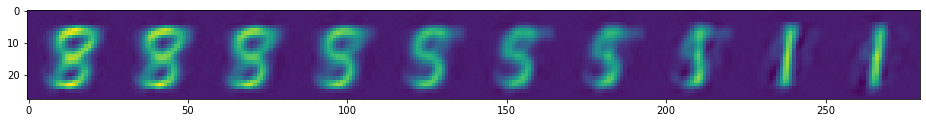

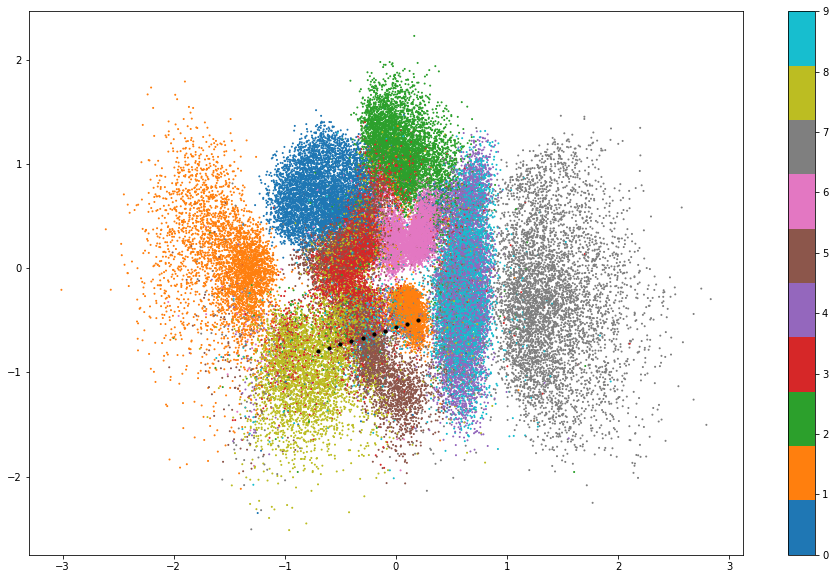

In [170]:
import numpy as np

num_samples = 10

z0 = [-0.7, -0.8]
z1 = [0.2, -0.5]

l = np.linspace(0.0, 1.0, num_samples).reshape(-1, 1)
z0 = np.array([z0]).repeat(num_samples, axis=0)
z1 = np.array([z1]).repeat(num_samples, axis=0)
z_walk = z0 * (1.0 - l) + z1 * l

y_pre = model.decoder(torch.tensor(z_walk, dtype=torch.float)).detach().numpy()
y_samples = y_pre.reshape(-1, 28, 28).transpose((1, 0, 2)).reshape(28, 28 * num_samples)

plt.figure(figsize=(16, 2))
plt.imshow(y_samples)

x_input = torch.tensor(np.load("MNIST_x_train.npy"), dtype=torch.float).flatten(start_dim=1)
model.forward(x_input)
z = model.z.detach().numpy() # (60000, 2)
y_target = np.load("MNIST_y_train.npy") # 샘플 색 결정

plt.figure(figsize=(16, 10))
plt.scatter(z[:,0], z[:,1], c=y_target, cmap="tab10", s = 1)
plt.colorbar()
plt.scatter(z_walk[:,0], z_walk[:,1], c='black', s = 10)

### [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [151]:
from sklearn.manifold import TSNE

x_input = np.load("MNIST_x_train.npy").reshape(-1, 28*28) # (60000, 784)

x_embedded = TSNE(init="random", learning_rate="auto").fit_transform(x_input)

print(x_embedded.shape) # (60000, 2)

(60000, 2)


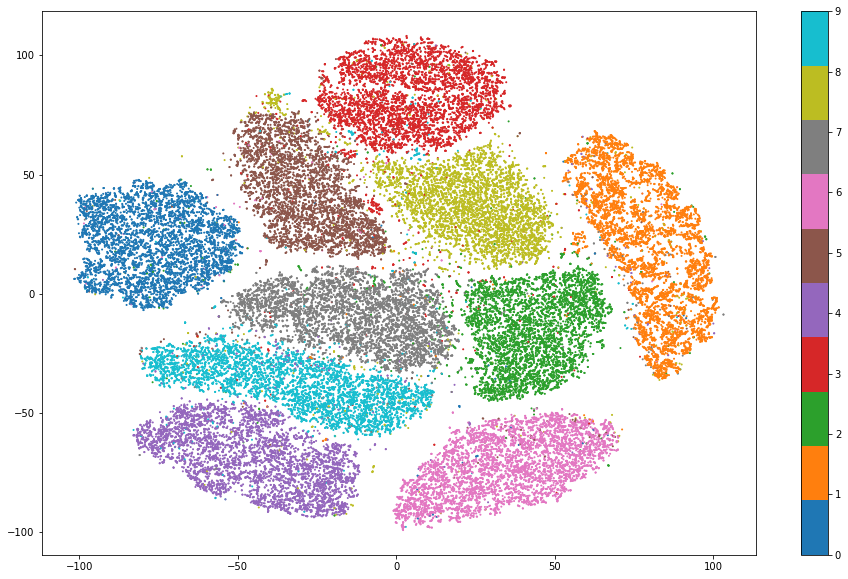

In [152]:
import matplotlib.pyplot as plt

y_target = np.load("MNIST_y_train.npy") # 샘플 색 결정

plt.figure(figsize=(16, 10))
plt.scatter(x_embedded[:,0], x_embedded[:,1], c=y_target, cmap="tab10", s = 1)
plt.colorbar()